In [33]:
import numpy as np
import os
import pandas as pd
import re
from pandas_ods_reader import read_ods
import sys
from copy import deepcopy

data_path = 'equation_genetic.csv'
VARIANT = 0

In [2]:
class Function:
    def __init__(self, variant, path, absolute = True):
        self.variant = variant
        self.path = path
        self.func_str = self._get_function_str()
        self.absolute = absolute
        
        self.variables = [v for v in list(set(self.func_str)) if v.isalpha() ]
#         self.evaluate = np.vectorize(self.evaluate)

    def _get_function_str(self):
        f_str = "u^powU * w^powW * x^powX * y^powY * z^powZ + u^powU1 * w^powW1 * x^powX1 * y^powY1 * z^powZ1 + u^powU2 * w^powW2 * x^powX2 * y^powY2 * z^powZ2 + u^powU3 * w^powW3 * x^powX3 * y^powY3 * z^powZ3 + u^powU4 * w^powW4 * x^powX4 * y^powY4 * z^powZ4 = Result"
        df = pd.read_csv(self.path)
        self.data = df
        variables = list(df.columns.values)

        for var in variables:
            key = var.replace(" ", "")
            key = key[0].lower() + key[1:] if key[0] is not 'R' else key
            value = df[var][self.variant]
            f_str = re.sub(r"\b{}\b".format(key),str(value) ,f_str)

        f_str = f_str.replace('^', '**')
        f_str = f_str.replace(' ', '')
        
        sign = f_str[ f_str.index('=') + 1 ]
        replace_to = ['=-', '+'] if sign is '-' else ['=', '-'] 
        f_str = f_str.replace(replace_to[0], replace_to[1])
        
        
        return f_str
    
    def get_pairs(self, features):
        result = {}
        for value, var_name in zip(features, self.variables):
            result[var_name] = value
        return result
    
    
    def evaluate(self, features):
        f = self.func_str
        """
            params: dict
                u, w, x, y, z
        """

        if len(features.shape) == 1:
            for value, var_name in zip(features, self.variables):
                f = f.replace(var_name, str(value))
            y = eval(f)
            y = abs(y) if self.absolute else y
            return eval(f)  
        
        elif len(features.shape) == 2:
            out = []
            for line in features:
                f = self.func_str
                for value, var_name in zip(line, self.variables):
#                     print(f, value, var_name)
                    f = f.replace(var_name, str(value))
                y = eval(f)
                y = abs(y) if self.absolute else y
                out.append(y)  
            return np.array(out)
        else:
            raise('Something is going wrong :(')

In [214]:
np.set_printoptions(precision=4)


def sort_a_by_b(A,B):
    return np.array([a for _,a in sorted(zip(B,A))])

class Genetic:
    def __init__(self, n_features, population_size, init_bounds, epochs = 10_000, eps = 0.0001):
        self.epochs = epochs
        self.n_features = n_features
        self.population_size = population_size
        self.eps = eps
        self.X = np.random.randint(*init_bounds, [population_size, n_features])
        self.solution = None
        self.best_result = 99999999999.
        
        self.loss = []
        print(f'X.shape: {self.X.shape}')
    
    def fit(self, func_to_optimize, selection = "Turnir", select_rate = .5, single_crossing = True,\
           p_mutation = .05):
        
        self.select_rate = select_rate
        self.func = func_to_optimize
        self.single_crossing = single_crossing
        self.p_mutation = p_mutation
        
        
        X = self.X
        
        self._fit(X)
        
    def _fit(self, X):
        y_prev = self.y_prev
        for e in range(self.epochs):
            X, _ = self._select(X, restore_original = False)
            X = self._cross(X)
            X = self._mutation(X)
            X, y = self._replace(X)
            
            
            self.X = X
            y_best = min(y)
            
            self.loss.append(y_best)
            
            if y_best < self.best_result:
                self.best_result = y_best
                self.solution = X[np.argmin(y)]
            
            if y_best <= self.eps:
                print("\n\nDone! loss = ", y_best)
                self.best_result = y_best
                self.solution = X[np.argmin(y)]
                return 
            
            sys.stdout.write(f"\r{e}/{self.epochs} -- {y_best}, best: {self.best_result}")
            sys.stdout.flush()
            
        

        
    def _select(self, X, restore_original):
        if restore_original:
            selected_num = self.population_size
        else:
            selected_num = int(X.shape[0] * self.select_rate)
        
        y = self.func.evaluate(X)
        idxs_X = np.arange(X.shape[0])
        idxs_X_sorted = sort_a_by_b(idxs_X, y)
        
        X = X[idxs_X_sorted]
        X = X[:selected_num]
        y = y[:selected_num]
        return X, y
    
    def _cross(self, X):
        """
        Одноточечная (в третьем гене) + многоточечная (во втором и четвертом гене)
        """
        n = X.shape[0]
        pairs = [(p1, p2) for p1 in np.arange(n) for p2 in np.arange(p1+1,n)]
        
        children  = []
        if self.single_crossing:
            switch = 3 - 1
            for i, j in pairs:
                x1 = np.append(X[i][:switch], X[j][switch:])
                x2 = np.append(X[i][switch:], X[j][:switch])
                children.append(x1)
                children.append(x2)
                
        return np.array(children)
    
    def _mutation(self, X):
        """Каждый бит всех потомков мутирует с некоторой вероятностью p"""
        def _irradiate(x):
            x_ = np.empty_like(x)
            for i in range(self.n_features):
                k =  np.random.uniform()
                if self.p_mutation >= k:
                    x_[i] = np.random.randint(-1000, 1000)
                else:
                    x_[i] = x[i]
            return x_
        
        new_X = []
        for x in X:
            x_ = _irradiate(x)
            new_X.append(x_)
        new_X = np.array(new_X)
        return new_X
    
    def _replace(self, X):
        """Произвести больше потомков, и оставить популяцию такого 
        же размера, как старая, но состоящую из более пригодных потомков
        """
        n = self.population_size
        X = self._select(X, restore_original = True)
        return X
        
    def get_sulution(self):
        return self.func.get_pairs(self.solution)
    
        
        

In [215]:
box = Genetic(n_features=5, population_size= 100, init_bounds=[-100, 100], epochs=5_000)
func = Function(variant=5, path=data_path)

X.shape: (100, 5)


In [216]:
%%time
box.fit(func_to_optimize=func, p_mutation=.3, select_rate=0.5)

39/5000 -- 2, best: 1

Done! loss =  0
Wall time: 10.6 s


<IPython.core.display.Javascript object>


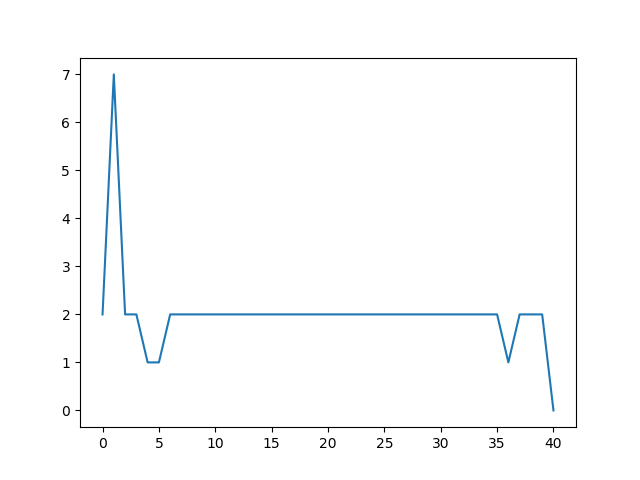

In [217]:
plt.plot(box.loss)

In [206]:
box.get_sulution()

{'w': 0, 'u': 842, 'y': 23, 'x': 294, 'z': 862}

In [218]:
print(func.evaluate(box.solution))

0
